# Image Processing SS 18 - Assignment - 07

### Deadline is 6.6.2016 at 08:00 o'clock

Please solve the assignments together with a partner.
I will run every notebook. Make sure the code runs through. Select `Kernel` -> `Restart & Run All` to test it.
Please strip the output from the cells, either select `Cell` -> `All Output` -> `Clear` or use the `nb_strip_output.py` script / git hook.

In [1]:
# display the plots inside the notebook
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
import scipy.io.wavfile
from skimage.data import astronaut
from skimage.color import rgb2gray

from __future__ import division
import random
try:
    from StringIO import StringIO as BytesIO
except ImportError:
    from io import BytesIO
    
try:
    import urllib.request as urllib2
except ImportError:
    import urllib2
    
    
from numpy.fft import fft2 as numpy_fft2, ifft2 as numpy_ifft2

from PIL import Image
import itertools
import IPython
import math

pylab.rcParams['figure.figsize'] = (14, 14)   # This makes the plot bigger

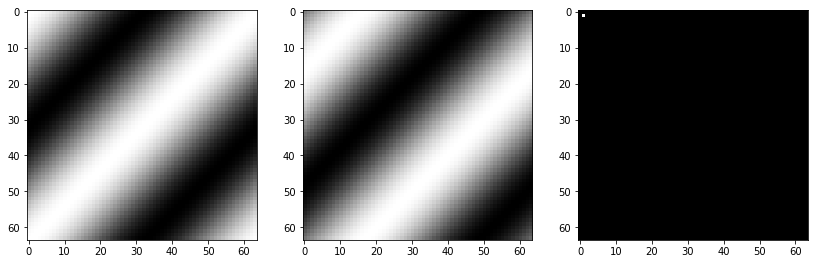

In [3]:
# Playground to get some intuition for 2d fourier transfromation
ft = np.zeros((64,64))

# set some random coefficents and see what happens
# ft[0, 1] = 1
ft[1, 1] = 1
# ft[10, 10] = 1

plt.subplot(131)
plt.imshow(np.real(numpy_ifft2(ft)), cmap='gray')
plt.subplot(132)
plt.imshow(np.imag(numpy_ifft2(ft)), cmap='gray')
plt.subplot(133)
plt.imshow(ft, cmap='gray')
plt.show()

# Exercise 1 - 2D DFT - 2 Points
Implement the 2D Discrete Fourier Transfromation with [Matrix Multiplication](https://en.wikipedia.org/wiki/DFT_matrix). You can use your code from the last assignment to compute the dct matrix.

Chessboard


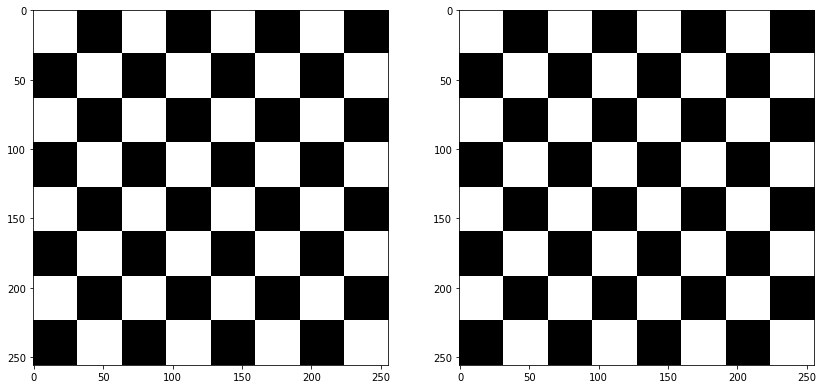

Numpy Implementation


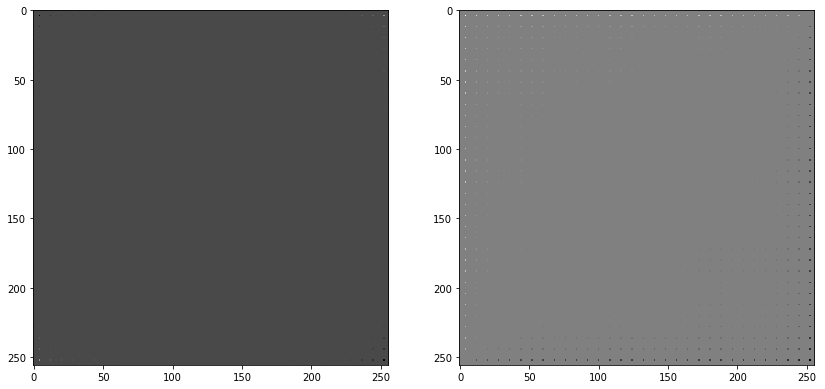

Own Implementation


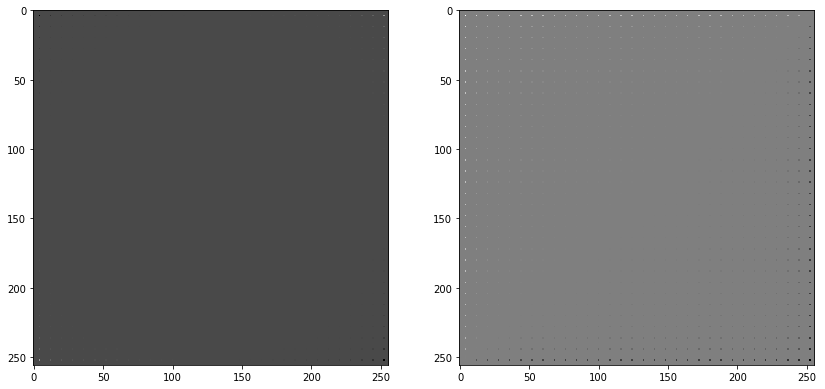

In [4]:
def dft_matrix(n):
    """
    Returns the Discrete Fourier Transformation Matrix of order `n`.
    """
    dft = np.zeros((n,n))
    omega = np.exp( -2  * np.pi * 1j / n)
    i, j = np.meshgrid(np.arange(n), np.arange(n))
    W = np.power(omega, i * j) / np.sqrt(n)
    
    return W

def dft2d(img):
    """
    Returns the 2d discrete fourier transformation
    """
    # your code here
    W = dft_matrix(img.shape[0])
    return W.dot(img).dot(W)


def inv_dft2d(x):
    """
    Returns the 2d inverse discrete fourier transformation
    """
    # your code here
    W = np.conj(dft_matrix(x.shape[0]))
    return W.dot(x).dot(W)


def chess_board(n=8, field_size=32):
    board = np.zeros((n*field_size, n*field_size))
    s = field_size
    for i in range(n):
        for j in range(n):
            if (i + j) % 2 == 0:
                board[i*s:(i+1)*s, j*s:(j+1)*s] = 1
    return board

print("Chessboard")
plt.subplot(121)
plt.imshow(chess_board(), cmap='gray')
plt.subplot(122)
plt.imshow(chess_board(), cmap='gray')
plt.show()
print("Numpy Implementation")
plt.subplot(121)
plt.imshow(np.real(numpy_fft2(chess_board())), cmap='gray')
plt.subplot(122)
plt.imshow(np.imag(numpy_ifft2(chess_board())), cmap='gray')
plt.show()
print("Own Implementation")
plt.subplot(121)
plt.imshow(np.real(dft2d(chess_board())), cmap='gray')
plt.subplot(122)
plt.imshow(np.imag(inv_dft2d(chess_board())), cmap='gray')
plt.show()

# Exercise 3 - High and Low Pass filter with the 2D fourier transfromation

In [5]:
def high_pass(img_ft, n):
    """Removes the low frequencies"""
    ft = img_ft.copy()
    ft[:n, :n] = 0
    ft[-n:, :n] = 0
    ft[-n:, -n:] = 0
    ft[:n, -n:] = 0
    return ft

def low_pass(img_ft, n):
    """Removes the high frequencies"""
    # your code here
    ft = img_ft.copy()
    w, h = ft.shape
    half = int(h/2)
    
    ft[n:-n,:] = 0
    ft[:, n:-n] = 0
    
    return ft
    
def band_pass(img_ft, low, high):
    """Only perserve the frequencies between low and high"""
    # your code here
    ft = img_ft.copy()
    return high_pass(low_pass(ft, high), low)
    
def inv_dft_and_plot(img_ft):
    plt.imshow(np.real(inv_dft2d(img_ft)), cmap='gray')
    plt.show()

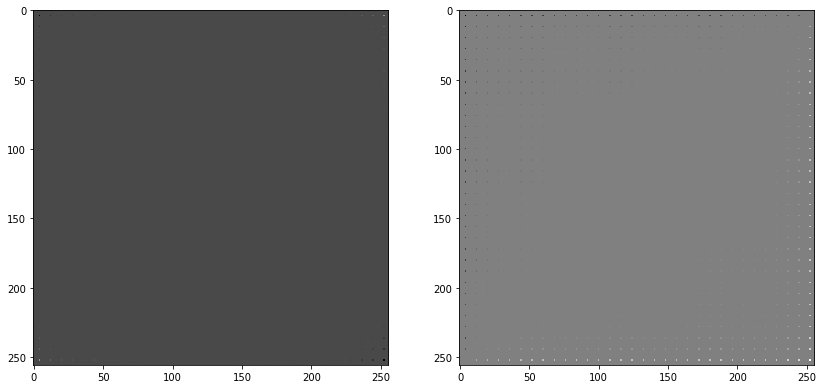

In [6]:
chess_board_ft = dft2d(chess_board())

# display frequency domain of the chess_board
plt.subplot(121)
plt.imshow(np.real(chess_board_ft), cmap='gray')
plt.subplot(122)
plt.imshow(np.imag(chess_board_ft), cmap='gray')
plt.show()

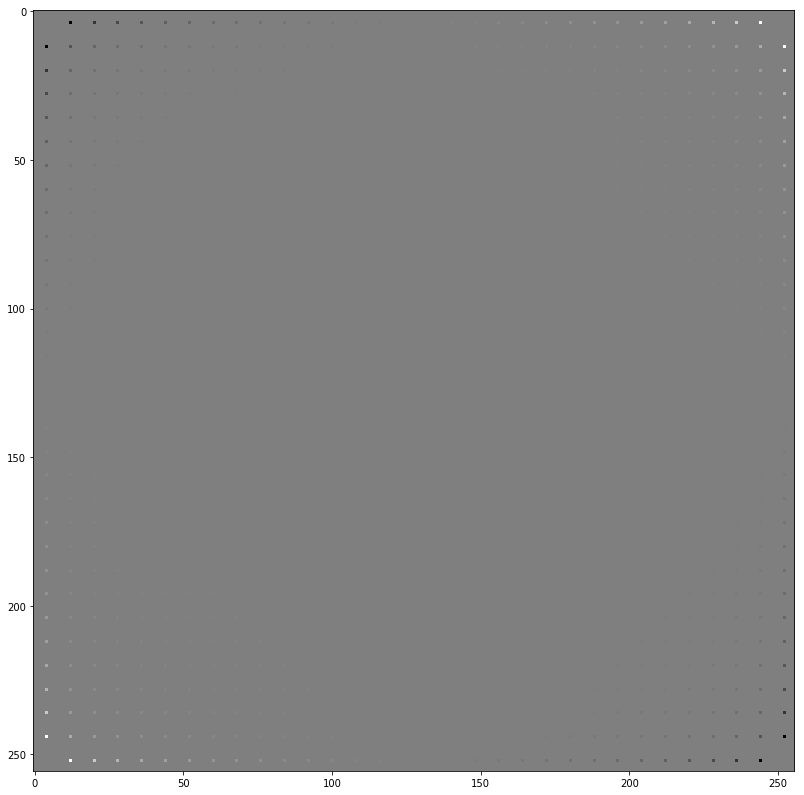

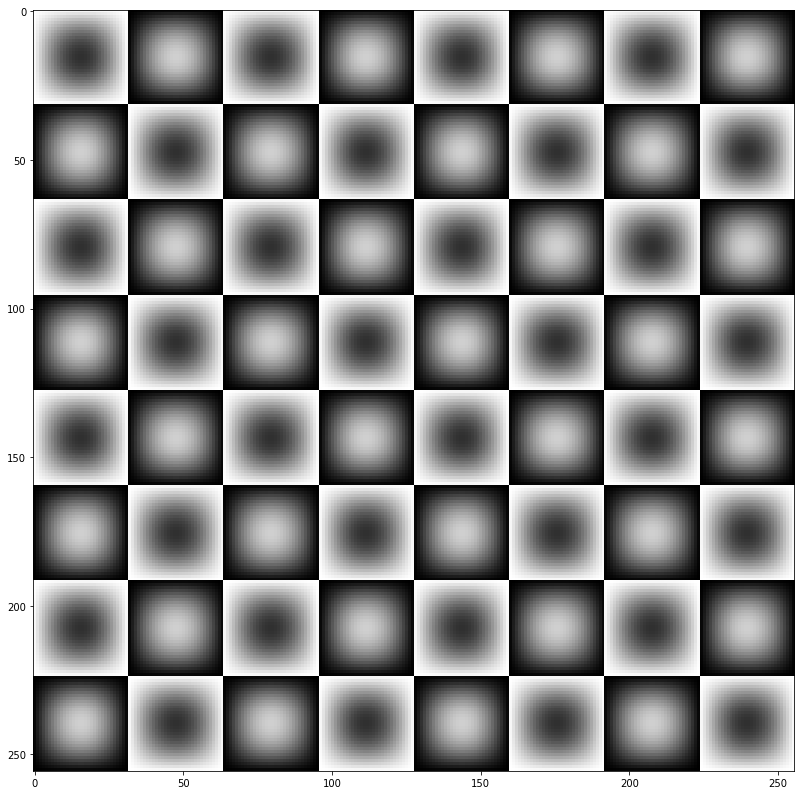

In [7]:
# remove the low frequiencies of the chess board
chess_high_feq = high_pass(chess_board_ft, 5)
plt.imshow(np.real(chess_high_feq), cmap='gray')
plt.show()
inv_dft_and_plot(chess_high_feq)

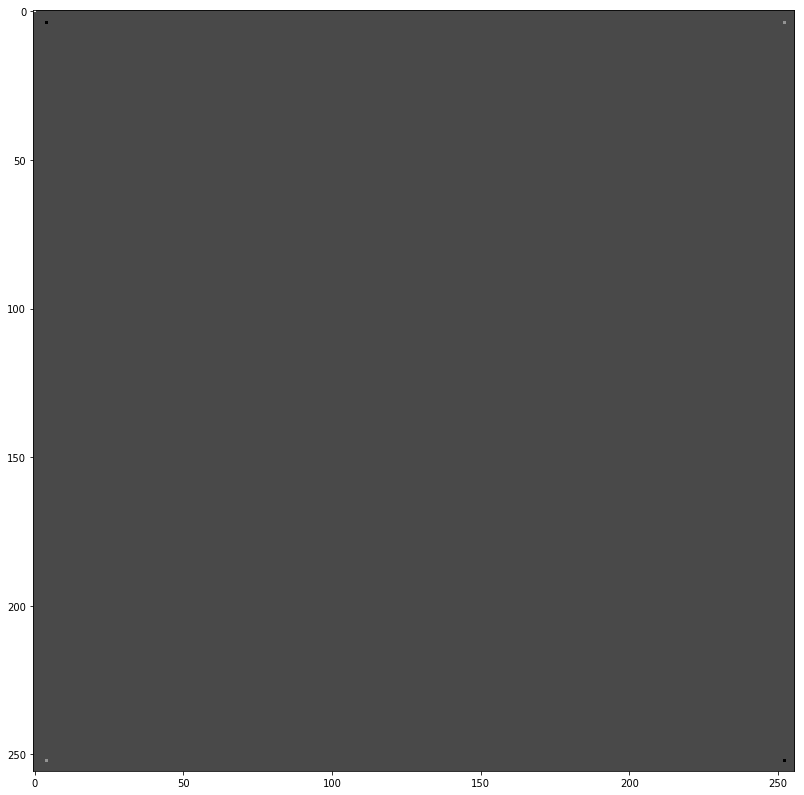

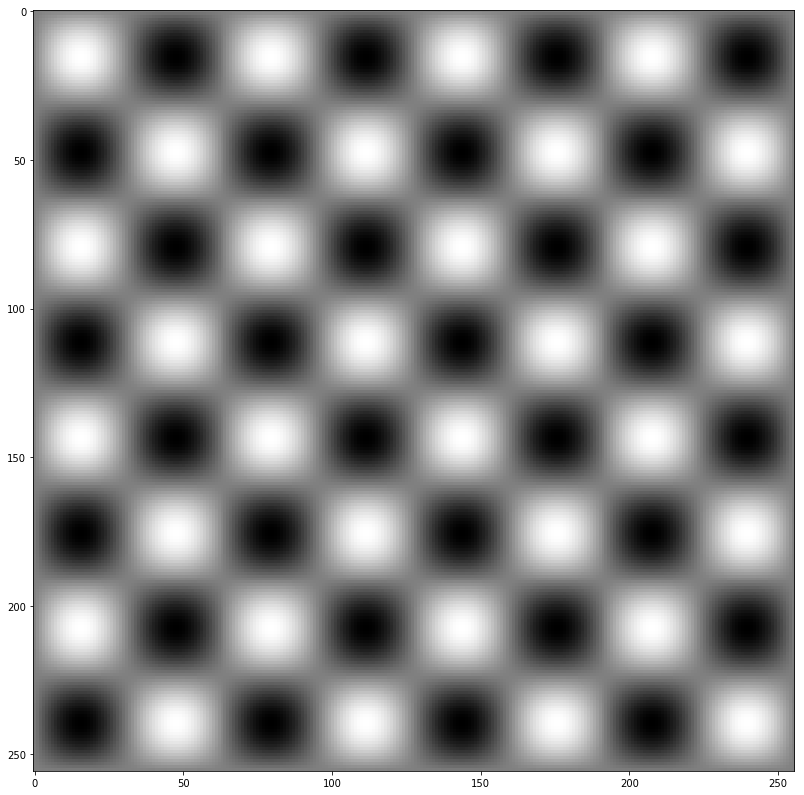

In [8]:
# remove the high frequiencies of the chess board
chess_low_feq = low_pass(chess_board_ft, 10)
plt.imshow(np.real(chess_low_feq), cmap='gray')
plt.show()
inv_dft_and_plot(chess_low_feq)

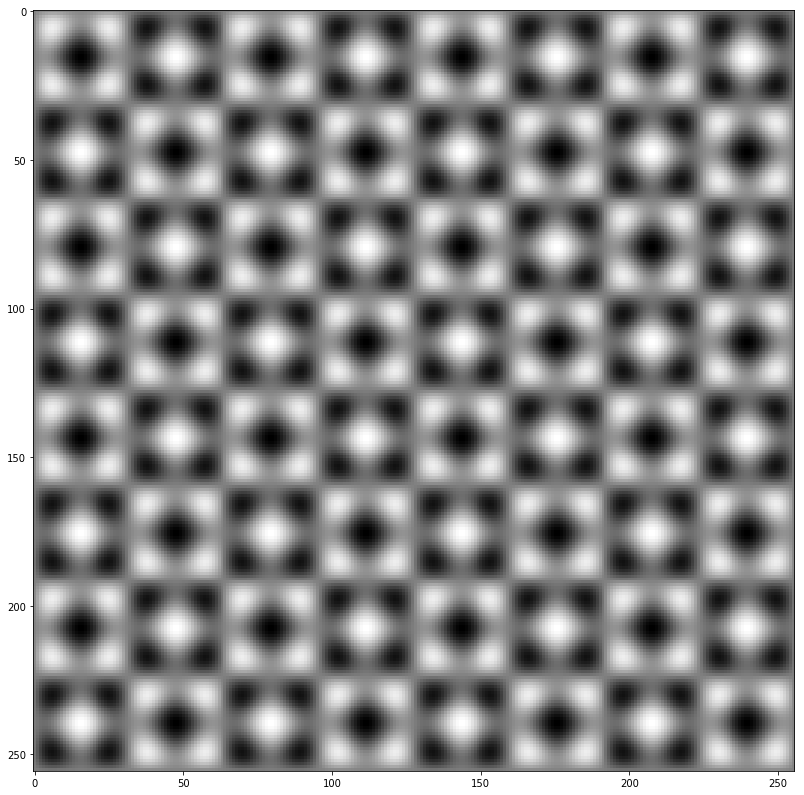

In [9]:
# remove the high frequiencies of the chess board
chess_medium_feq = band_pass(chess_board_ft, 5, 15)
inv_dft_and_plot(chess_medium_feq)

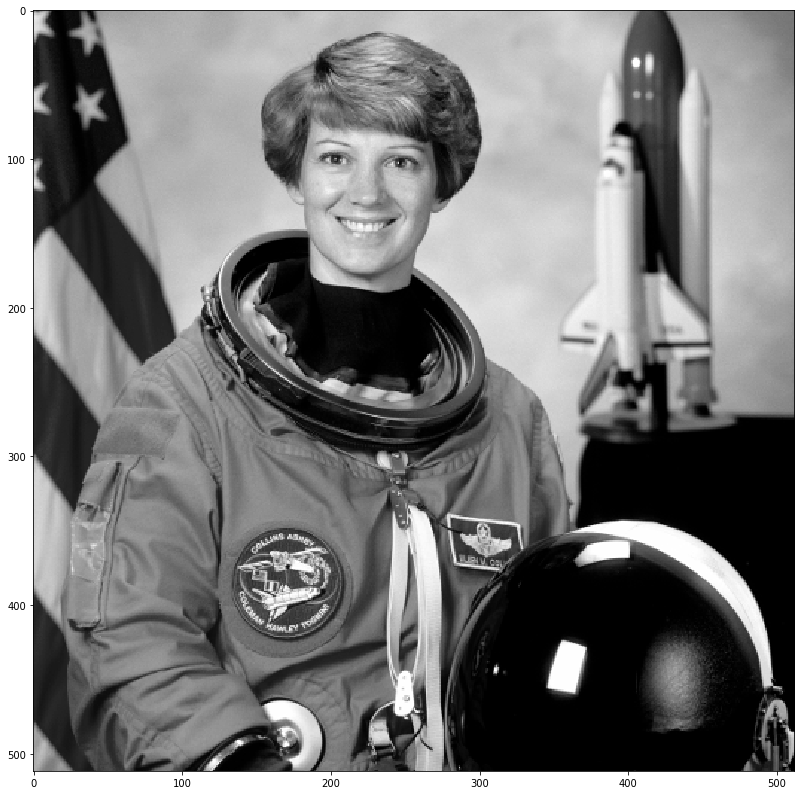

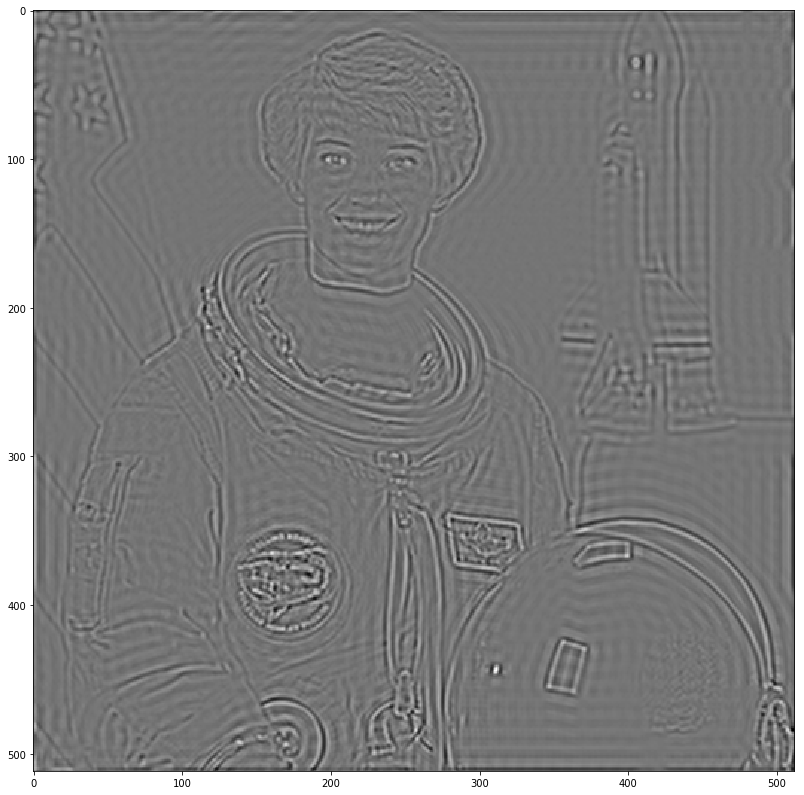

In [10]:
img = rgb2gray(astronaut() / 255)
plt.imshow(img, cmap='gray')
plt.show()
# filter all frequencies corresponding to the coeffientns between 48 and 128.
# your code here
astronanaut_feq = band_pass(dft2d(img), 48, 128)
inv_dft_and_plot(astronanaut_feq)

# Exercise 3 - FFT - 5 Points

Implement the fast fourier transformation. 
Use the [Cooley-Tukey](https://en.wikipedia.org/wiki/Cooley%E2%80%93Tukey_FFT_algorithm) algorithm.

In [17]:
def _fft(x):
    N = len(x)
    
    #in case list only contains one element
    if N <= 1: 
        return x
    
    # separates list into even and odd part
    even = _fft(x[0::2])
    odd =  _fft(x[1::2])
    
    T = [np.exp(-2j * np.pi * k/N) * odd[k] for k in range(N//2)]
    
    return [even[k] + T[k] for k in range(N//2)] + [even[k] - T[k] for k in range(N//2)]

def fft(matrix):
    fft_rows = np.array([_fft(row) for row in matrix])
    #transposing to also use fft on columns, transposing again to get result
    return np.array([_fft(row) for row in fft_rows.transpose()]).transpose()

In [18]:
img = rgb2gray(astronaut() / 255)
fft_img = fft(img)
# fft_img = numpy_fft2(img)

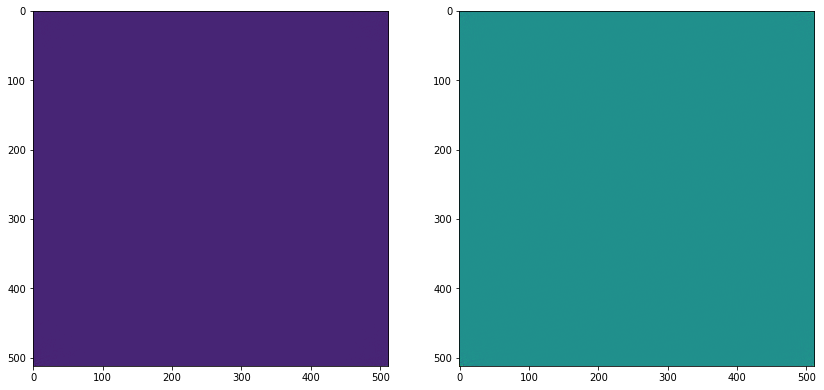

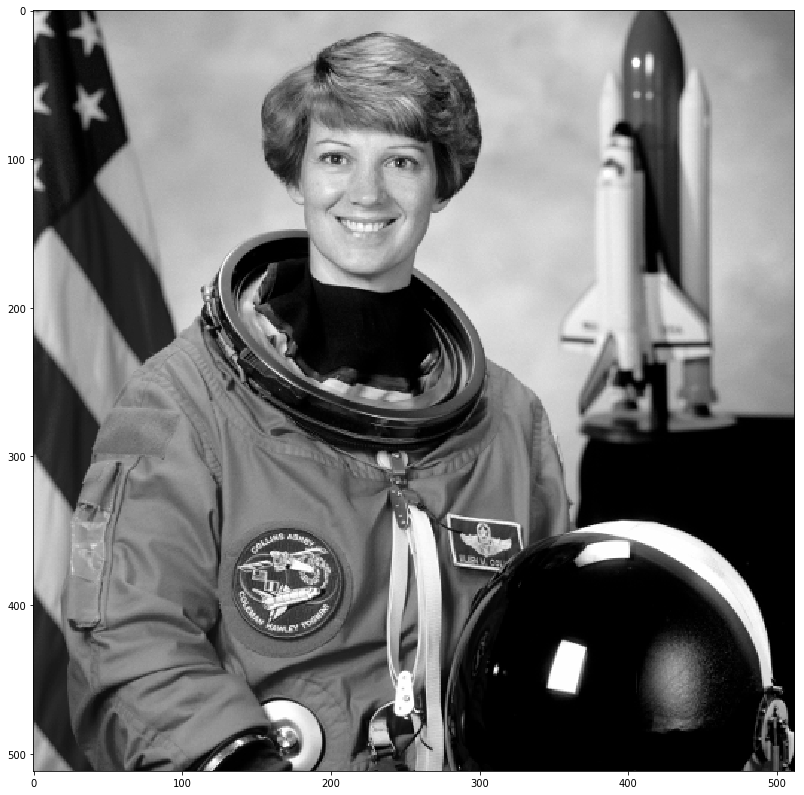

In [19]:
plt.subplot(121)
plt.imshow(np.real(fft_img))
plt.subplot(122)
plt.imshow(np.imag(fft_img))
plt.show()

#reverse to test if fft works
inv_dft_and_plot(fft_img)